In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import argparse
import time
from typing import Tuple, Optional, Dict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from env import MazeEnv
from agent import MyAgents

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def simulation_config(config_path: str, new_agent: bool = True) -> Tuple[MazeEnv, Optional[MyAgents], Dict]:
    """
    Configure the environment and optionally an agent using a JSON configuration file.

    Args:
        config_path (str): Path to the configuration JSON file.
        new_agent (bool): Whether to initialize the agent. Defaults to True.

    Returns:
        Tuple[MazeEnv, Optional[MyAgent], Dict]: Configured environment, agent (if new), and the configuration dictionary.
    """
    
    # Read config
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)

    # Env configuration
    env = MazeEnv(
        size=config.get('grid_size'),                               # Grid size
        walls_proportion=config.get('walls_proportion'),            # Walls proportion in the grid
        num_dynamic_obstacles=config.get('num_dynamic_obstacles'),  # Number of dynamic obstacles
        num_agents=config.get('num_agents'),                        # Number of agents
        communication_range=config.get('communication_range'),      # Maximum distance for agent communications
        max_lidar_dist_main=config.get('max_lidar_dist_main'),      # Maximum distance for main LIDAR scan
        max_lidar_dist_second=config.get('max_lidar_dist_second'),  # Maximum distance for secondary LIDAR scan
        max_episode_steps=config.get('max_episode_steps'),          # Number of steps before episode termination
        render_mode=config.get('render_mode', None),
        seed=config.get('seed', None)                               # Seed for reproducibility
    )

    # Agent configuration
    agent = MyAgents(num_agents=config.get('num_agents'), state_dim=22,action_dim=7) if new_agent else None

    return env, agent, config

In [12]:
# Environment and agent configuration
env, agent, config = simulation_config('config.json')
max_episodes = config.get('max_episodes')

device = agent.device

# Metrics to follow the performance
all_rewards = []
total_reward = 0
episode_count = 0

# Initial reset of the environment
#state, info = env.reset()
time.sleep(1)
try:
    while episode_count < max_episodes:
        state, info = env.reset()
        done = False
        
        while not done:
            # Determine agents actions
            actions = agent.get_action(state)

            # Execution of a simulation step
            next_state, rewards, terminated, truncated, info = env.step(actions)
            total_reward += np.sum(rewards)

            agent.replay_buffer.append((state, actions, rewards, next_state, terminated))
            # Update agent policy
            agent.update_policy()

            # Update state
            state = next_state
            done = terminated or truncated
        # Update the target network
        agent.update_target_networks()
        
        # Display of the step information
        print(f"\rEpisode {episode_count + 1}, Step {info['current_step']}, "
                f"Reward: {total_reward:.2f}, "
                f"Evacuated: {len(info['evacuated_agents'])}, "
                f"Deactivated: {len(info['deactivated_agents'])}", end='')
        
        # Pause
        time.sleep(1)
        
        # If the episode is terminated
        if terminated or truncated:
            print("\r")
            episode_count += 1
            all_rewards.append(total_reward)
            total_reward = 0
            
            if episode_count < max_episodes:
                state, info = env.reset()

except KeyboardInterrupt:
    print("\nSimulation interrupted by the user")

finally:
    env.close()


C:\Users\etien\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 1, Step 214, Reward: -19523.30, Evacuated: 0, Deactivated: 2
Episode 2, Step 61, Reward: -1810.40, Evacuated: 0, Deactivated: 2
Episode 3, Step 27, Reward: -2502.90, Evacuated: 0, Deactivated: 2
Episode 4, Step 165, Reward: -14818.20, Evacuated: 0, Deactivated: 2
Episode 5, Step 37, Reward: 893.90, Evacuated: 1, Deactivated: 1
Episode 6, Step 34, Reward: -1105.70, Evacuated: 0, Deactivated: 2
Episode 7, Step 33, Reward: -1505.10, Evacuated: 0, Deactivated: 2
Episode 8, Step 17, Reward: -802.60, Evacuated: 0, Deactivated: 2
Episode 9, Step 110, Reward: -7413.40, Evacuated: 1, Deactivated: 1
Episode 10, Step 33, Reward: -606.00, Evacuated: 0, Deactivated: 2
Episode 11, Step 45, Reward: -1607.40, Evacuated: 0, Deactivated: 2
Episode 12, Step 35, Reward: -1405.60, Evacuated: 0, Deactivated: 2
Episode 13, Step 24, Reward: -1003.80, Evacuated: 0, Deactivated: 2
Episode 14, Step 61, Reward: -6106.10, Evacuated: 0, Deactivated: 2
Episode 15, Step 23, Reward: -1403.20, Evacuated: 0, Dea

In [21]:
# Environment and agent configuration
env, agent, config = simulation_config('config.json')
max_episodes = config.get('max_episodes')

device = agent.device

# Metrics to follow the performance
all_rewards = []
total_reward = 0
episode_count = 0

# Initial reset of the environment
state, info = env.reset()
time.sleep(1)

try:
    while episode_count < max_episodes:
        # Reset the environment
        state, info = env.reset()
        done = False
        
        while not done:
            actions = agent.get_action(state, env.action_space)
            next_state, reward, done, truncated, info = env.step(actions)
            agent.replay_buffer.append((state, actions, reward, next_state, done))

            if len(agent.replay_buffer) > agent.batch_size:
                batch = random.sample(agent.replay_buffer, agent.batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                # Move tensors to GPU directly
                
                states_tensor_list = [torch.tensor(np.array(state), dtype=torch.float32) for state in states]
                next_states_tensor_list = [torch.tensor(np.array(next_state), dtype=torch.float32) for next_state in next_states]
                states_tensor = torch.stack(states_tensor_list).flatten(start_dim=1).to(device)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=device)
                next_states_tensor = torch.stack(next_states_tensor_list).flatten(start_dim=1).to(device)
                dones_tensor = torch.tensor(dones, dtype=torch.float32, device=device)

                # Compute Q-values
                q_values = agent.ai(states_tensor)
                next_q_values = agent.target_network(next_states_tensor)
                print(torch.max(next_q_values, dim=1))
                print(rewards_tensor.shape)
                print(dones_tensor.shape)
                target_q_values = rewards_tensor + agent.gamma * torch.max(next_q_values, dim=1)[0] * (1 - dones_tensor)

                # Convert actions to indices
                action_indices = [[env.action_space.index(action) for action in action_list] for action_list in actions]
                actions_tensor = torch.tensor(action_indices, dtype=torch.long, device=agent.device)

                selected_q_values = q_values.gather(1, actions_tensor).mean(dim=1)

                loss = agent.loss_fn(selected_q_values, target_q_values.detach())
                agent.optim.zero_grad()
                loss.backward()
                agent.optim.step()

            state = next_state
            total_reward += reward

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        
        # Update target network
        if episode_count % 10 == 0:
            agent.target_network.load_state_dict(agent.ai.state_dict())

        if episode_count % 50 == 0:
            print(f"Episode {episode_count}, Reward: {total_reward}")
            
        # Pause
        time.sleep(1)
        
        # If the episode is terminated
        if done or truncated:
            print("\r")
            episode_count += 1
            all_rewards.append(total_reward)
            total_reward = 0
            
            if episode_count < max_episodes:
                state, info = env.reset()

except KeyboardInterrupt:
    print("\nSimulation interrupted by the user")

finally:
    env.close()


Episode 0, Reward: [ -102.9 -2700.3  -902.1 -2200.8]

torch.return_types.max(
values=tensor([0.7853, 0.3882, 0.7632, 0.3646, 1.1016, 1.1825, 0.7055, 1.2483, 0.6554,
        0.6751, 0.6955, 0.6307, 0.3731, 1.1976, 1.7463, 0.6784, 1.7775, 2.4281,
        0.6367, 1.7396, 0.7273, 0.3710, 1.1331, 2.4281, 0.3731, 0.3705, 0.7549,
        0.7790, 0.1174, 2.4689, 0.3710, 0.3646], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([3, 5, 3, 5, 5, 5, 3, 5, 3, 3, 3, 3, 5, 5, 5, 3, 5, 5, 3, 5, 3, 5, 5, 5,
        5, 5, 3, 3, 2, 5, 5, 5], device='cuda:0'))
torch.Size([32, 4])
torch.Size([32])


RuntimeError: The size of tensor a (4) must match the size of tensor b (32) at non-singleton dimension 1

In [14]:
import simulate

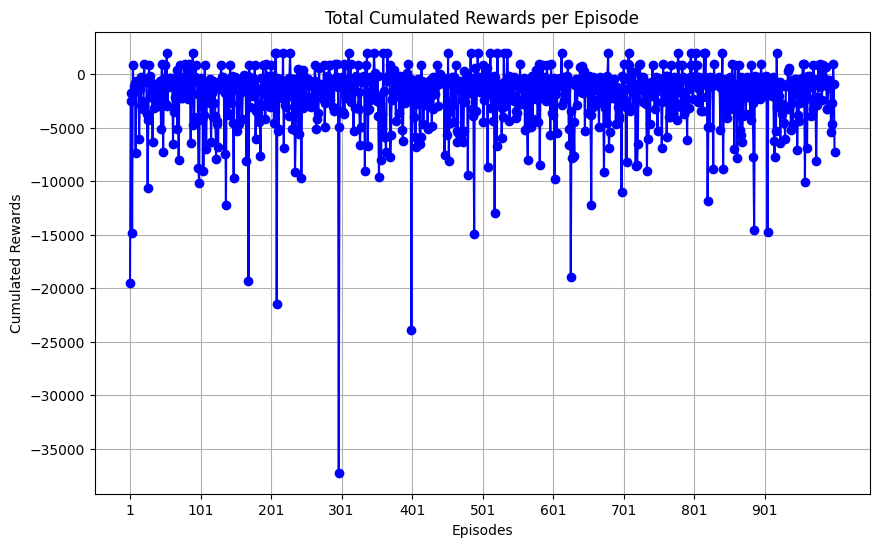

In [15]:
simulate.plot_cumulated_rewards(all_rewards)